In [37]:
#!pip install transformers
#!pip install wandb

In [38]:
import os
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

In [39]:
from transformers import AutoTokenizer, BertModel, Wav2Vec2ForCTC, Wav2Vec2Processor

import torch
import torch.nn as nn
import torchaudio
import torchaudio.functional as F

import torch.optim as optim

import re
from torch.utils.data import Dataset, DataLoader, Subset

import pandas as pd
import numpy as np

import pickle

import wandb

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score

from huggingface_hub import login

from typing import DefaultDict

In [40]:
from google.colab import userdata
hf_token = userdata.get('HF_TOKEN')
wandb_token = userdata.get('WAND_TOKEN')

In [ ]:
%env HF_TOKEN_ENV=$hf_token
!wget -nc --header "Authorization: Bearer ${HF_TOKEN_ENV}" https://huggingface.co/datasets/asapp/slue/resolve/main/data/voxceleb/dev.tsv
!wget -nc --header "Authorization: Bearer ${HF_TOKEN_ENV}" https://huggingface.co/datasets/asapp/slue/resolve/main/data/voxceleb/fine-tune.tsv
!wget -nc --header "Authorization: Bearer ${HF_TOKEN_ENV}" https://huggingface.co/datasets/asapp/slue/resolve/main/data/voxceleb/test.tsv

!wget -nc --header "Authorization: Bearer ${HF_TOKEN_ENV}" https://huggingface.co/datasets/asapp/slue/resolve/main/data/voxceleb/audio/dev.zip
!wget -nc --header "Authorization: Bearer ${HF_TOKEN_ENV}" https://huggingface.co/datasets/asapp/slue/resolve/main/data/voxceleb/audio/fine-tune.zip
!wget -nc --header "Authorization: Bearer ${HF_TOKEN_ENV}" https://huggingface.co/datasets/asapp/slue/resolve/main/data/voxceleb/audio/test.zip

In [42]:
if not os.path.exists("dev_raw"):
    print("dev_raw folder not found. Unzipping dev.zip...")
    !unzip -q dev.zip
else:
    print("dev_raw folder already exists. Skipping unzip.")

if not os.path.exists("fine-tune_raw"):
    print("fine-tune_raw folder not found. Unzipping fine-tune.zip...")
    !unzip -q fine-tune.zip
else:
    print("fine-tune_raw folder already exists. Skipping unzip.")

if not os.path.exists("test_raw"):
    print("test_raw folder not found. Unzipping test.zip...")
    !unzip -q test.zip
else:
    print("test_raw folder already exists. Skipping unzip.")

dev_raw folder already exists. Skipping unzip.
fine-tune_raw folder already exists. Skipping unzip.
test_raw folder already exists. Skipping unzip.


In [43]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
NUM_EPOCHS = 5
BATCH_SIZE = 16

SAVED_CUSTOM_BERT_TOKEN_MAX_LEN_PATH  = "max_len.pkl"
SAVED_CUSTOM_BERT_TOKENIZER_DIR  = "bert_tokenizer_local"
SAVED_CUSTOM_BERT_MODEL_PATH = "custom_bert_model.bin"
SAVED_TARGET_CAT_PATH = "categories.bin"
TRAIN_DS_PATH = "fine-tune.tsv"
TEST_DS_PATH = "test.tsv"
BERT_BASE_MODEL = "google-bert/bert-base-uncased"
INTERMEDIATE_CUSTOM_BERT_LAYER_SIZE = 30

SAVED_AUDIO_MODEL_DIR_PATH = "wav2vec2_local"
AUDIO_BASE_MODEL = "facebook/wav2vec2-base-960h"
PROCESSOR_NAME = "preprocessor_config.json"
MODEL_NAME = "config.json"

SENTIMENT_MODALITIES = ["Neutral", "Positive", "Negative"]

In [44]:
class CustomBertDataset(Dataset):
  def __init__(self, file_path,audio_folder, model_path=BERT_BASE_MODEL,saved_target_cats_path=SAVED_TARGET_CAT_PATH, saved_max_len_path=SAVED_CUSTOM_BERT_TOKEN_MAX_LEN_PATH):
      self.model_path = model_path
      self.tokenizer = AutoTokenizer.from_pretrained(self.model_path)
      self.lines = open(file_path).readlines()
      self.lines = np.array([[re.split(r'\t+', line.replace("\n",""))[1], re.split(r'\t+', line.replace("\n",""))[4], re.split(r'\t+', line.replace("\n",""))[0]]  for i, line in enumerate(self.lines) if line != "\n" and i != 0])

      self.elem_cats = self.lines[:,1]
      self.corpus =  self.lines[:,0]
      self.audio_files_id = self.lines[:,2]

      # We have to proceed in this order here
      self.corpus = [sent.lower() for sent, cat in zip(self.corpus, self.elem_cats)  if cat in SENTIMENT_MODALITIES]
      self.audio_files = np.array([os.path.join(audio_folder, f"{file_name}.flac") for file_name, cat in zip(self.audio_files_id, self.elem_cats) if  cat in SENTIMENT_MODALITIES])
      self.elem_cats = [cat for cat in self.elem_cats if cat in SENTIMENT_MODALITIES]

      self.unique_cats = sorted(list(set(self.elem_cats)))
      self.num_class = len(self.unique_cats)
      self.cats_dict = {cat:i for i, cat in enumerate(self.unique_cats)}
      self.targets = np.array([self.cats_dict[cat] for cat in self.elem_cats])

      torch.save(self.unique_cats, saved_target_cats_path)
      self.tokenizer.save_pretrained(SAVED_CUSTOM_BERT_TOKENIZER_DIR)

      """entry_dict = DefaultDict(list)
      for i in range(len(self.corpus)):
          entry_dict[self.targets[i]].append(self.corpus[i])

      self.final_corpus = []
      self.final_targets = []
      n=0
      while n < len(self.corpus):
        for key in entry_dict.keys():
          if len(entry_dict[key]) > 0:
            self.final_corpus.append(entry_dict[key].pop(0))
            self.final_targets.append(key)
            n+=1

      self.corpus = np.array(self.final_corpus)
      self.targets = np.array(self.final_targets)"""

      self.max_len = 0
      for sent in self.corpus:
          input_ids = self.tokenizer.encode(sent, add_special_tokens=True)
          self.max_len = max(self.max_len, len(input_ids))

      self.max_len = min(self.max_len, 512)
      print(f"Max length : {self.max_len}")
      print(f"Nombre de classes : {self.num_class}")
      print(f"Exemples de targets : {np.unique(self.targets)}")

      # Save max_len
      with open(saved_max_len_path, 'wb') as f:
          pickle.dump(self.max_len, f)
      print(f"max_len saved to {saved_max_len_path}")

  def __len__(self):
    return len(self.elem_cats)

  def __getitem__(self, idx):
    text = self.corpus[idx]
    target = self.targets[idx]

    # Vérification : target doit être entre 0 et num_class - 1
    if target < 0 or target >= self.num_class:
      raise ValueError(f"Target out of bounds: {target} not in [0, {self.num_class - 1}]")


    encoded_input = self.tokenizer.encode_plus(text, max_length=self.max_len, padding="max_length", truncation=True, return_tensors='pt')
    return encoded_input['input_ids'].squeeze(0), encoded_input['attention_mask'].squeeze(0), torch.tensor(target, dtype=torch.long), self.audio_files[idx]
    #return np.array(encoded_input), torch.tensor(target, dtype=torch.long)

In [45]:
class CustomBertModel(nn.Module):
    def __init__(self, num_class, model_path=BERT_BASE_MODEL):
        super(CustomBertModel, self ).__init__()
        self.model_path = model_path
        self.num_class = num_class

        self.bert = BertModel.from_pretrained(self.model_path)
        # Freeze of the parameters of this layer for the training process
        for param in self.bert.parameters():
            param.requires_grad = False
        #self.proj_intermediate = nn.Sequential(nn.Linear(self.bert.config.hidden_size, INTERMEDIATE_CUSTOM_BERT_LAYER_SIZE),nn.Linear(INTERMEDIATE_CUSTOM_BERT_LAYER_SIZE, INTERMEDIATE_CUSTOM_BERT_LAYER_SIZE), INTERMEDIATE_CUSTOM_BERT_LAYER_SIZE),nn.Linear(INTERMEDIATE_CUSTOM_BERT_LAYER_SIZE, INTERMEDIATE_CUSTOM_BERT_LAYER_SIZE))
        self.proj_lin = nn.Linear(self.bert.config.hidden_size, self.num_class)

    def forward(self, input_ids, attention_mask):
        x = self.bert(input_ids=input_ids, attention_mask=attention_mask)

        x = x.last_hidden_state[:,0,:]
        #x = self.proj_intermediate(x)
        x = self.proj_lin(x)
        return x

In [46]:
def train_step(model, train_dataloader, loss_fn, optimizer):

  num_iterations = len(train_dataloader)

  for i in range(NUM_EPOCHS):
    print(f"Training Epoch n° {i}")
    model.train()

    for j, batch in enumerate(train_dataloader):

      input = batch[:][0]
      attention = batch[:][1]
      target = batch[:][2]


      output = model(input.to(device), attention.to(device))


      loss = loss_fn(output, target.to(device))

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      run.log({"Training loss": loss})

      print(f"Epoch {i+1} | step {j+1} / {num_iterations} | loss : {loss}")


  #Save model
  torch.save(model.state_dict(), SAVED_CUSTOM_BERT_MODEL_PATH)
  print(f"Custom BERT Model saved at {SAVED_CUSTOM_BERT_MODEL_PATH}")

In [47]:
def eval_step(test_dataloader, loss_fn, num_class, saved_model_path=SAVED_CUSTOM_BERT_MODEL_PATH,saved_target_cats_path=SAVED_TARGET_CAT_PATH):

  y_pred = []
  y_true = []

  num_iterations = len(test_dataloader)
  # Load the saved model
  saved_model = CustomBertModel(num_class)
  saved_model.load_state_dict(torch.load(saved_model_path, weights_only=False)) # Explicitly set weights_only to False
  saved_model = saved_model.to(device)
  saved_model.eval()  # Set the model to evaluation mode
  print(f"Model loaded from path :{saved_model_path}")

  with torch.no_grad():
    for j, batch in enumerate(test_dataloader):

      input = batch[:][0]
      attention = batch[:][1]
      target = batch[:][2]


      output = saved_model(input.to(device), attention.to(device))

      loss = loss_fn(output, target.to(device))

      run.log({"Eval loss": loss})
      print(f"Step {j+1} / {num_iterations} | Eval loss : {loss}")
      y_pred.extend(output.cpu().numpy().argmax(axis=1))
      y_true.extend(target.cpu().numpy())

  class_labels = torch.load(saved_target_cats_path, weights_only=False)

  true_labels = [class_labels[i] for i in y_true]
  pred_labels = [class_labels[i] for i in y_pred]

  print(f"Accuracy : {accuracy_score(true_labels, pred_labels)}")

  cm = confusion_matrix(true_labels, pred_labels, labels=class_labels)
  df_cm = pd.DataFrame(cm, index=class_labels,columns=class_labels)
  sns.heatmap(df_cm, annot=True, fmt='d')
  plt.title("Confusion Matrix for Sentiment analysis dataset")
  plt.xlabel("Predicted Label")
  plt.ylabel("True Label")
  plt.show()

In [48]:
def eval_pipeline_step(test_dataloader, loss_fn, num_class, audio_model_dir=SAVED_AUDIO_MODEL_DIR_PATH, audio_model_name=MODEL_NAME, audio_processor_name=PROCESSOR_NAME, saved_model_path=SAVED_CUSTOM_BERT_MODEL_PATH,saved_target_cats_path=SAVED_TARGET_CAT_PATH):

  y_pred = []
  y_true = []

  num_iterations = len(test_dataloader)
  # Load the saved model
  saved_model = CustomBertModel(num_class)
  saved_model.load_state_dict(torch.load(saved_model_path, weights_only=False)) # Explicitly set weights_only to False
  saved_model = saved_model.to(device)
  saved_model.eval()  # Set the model to evaluation mode
  print(f"Model loaded from path :{saved_model_path}")

  audio_processor = None
  audio_model = None

  processor_path = os.path.join(audio_model_dir, audio_processor_name) # Check for a key file, like the preprocessor config
  model_path = os.path.join(audio_model_dir, audio_model_name) # Check for a key file, like the model config

  if os.path.exists(audio_model_dir) and os.path.exists(processor_path) and os.path.exists(model_path):
      print("Local Wav2Vec2 processor and model found. Loading from local directory.")
      audio_processor = Wav2Vec2Processor.from_pretrained(audio_model_dir)
      audio_model = Wav2Vec2ForCTC.from_pretrained(audio_model_dir)
  else:
      print("Local Wav2Vec2 processor and model not found. Downloading from Hugging Face Hub.")
      audio_processor = Wav2Vec2Processor.from_pretrained(AUDIO_BASE_MODEL)
      audio_model = Wav2Vec2ForCTC.from_pretrained(AUDIO_BASE_MODEL)

      # Optionally save the downloaded model and processor for future use
      audio_processor.save_pretrained(audio_model_dir)
      audio_model.save_pretrained(audio_model_dir)
      print(f"Wav2Vec2 processor and model downloaded and saved to {audio_model_dir}")

  # Move audio model to GPU
  audio_model = audio_model.to(device)
  audio_model.eval()

  with torch.no_grad():
    for j, batch in enumerate(test_dataloader):

      target = batch[:][2]
      audio_file_path = batch[:][3]

      encoded_inputs = []
      attention_masks = []

      bundle = torchaudio.pipelines.WAV2VEC2_ASR_BASE_960H
      sample_rate = bundle.sample_rate

      for audio_file in audio_file_path:
        waveform, sr = torchaudio.load(audio_file)
        if sr != sample_rate:
            print("Resampling")
            resampler = torchaudio.transforms.Resample(orig_freq=sr, new_freq=sample_rate)
            waveform = resampler(waveform)

        # Move waveform to GPU before processing
        input_values = audio_processor(waveform.squeeze().numpy(), sampling_rate=sample_rate, return_tensors="pt").input_values.to(device)

        with torch.no_grad():
            logits = audio_model(input_values).logits
        predicted_ids_hf = torch.argmax(logits, dim=-1)
        transcript_hf = audio_processor.decode(predicted_ids_hf[0].cpu().numpy()) # Move predicted_ids_hf back to CPU for decoding
        transcript_hf = transcript_hf.lower() if transcript_hf is not None else None

        encoded_input = test_dataloader.dataset.tokenizer.encode_plus(transcript_hf, max_length=test_dataloader.dataset.max_len, padding="max_length", truncation=True, return_tensors='pt')
        encoded_inputs.append(encoded_input['input_ids'].squeeze(0))
        attention_masks.append(encoded_input['attention_mask'].squeeze(0))

      text_input = torch.stack(encoded_inputs)
      attention = torch.stack(attention_masks)


      output = saved_model(text_input.to(device), attention.to(device))

      loss = loss_fn(output, target.to(device))

      run.log({"Pipeline Eval loss": loss})
      print(f"Step {j+1} / {num_iterations} | Pipeline Eval loss : {loss}")

      y_pred.extend(output.cpu().numpy().argmax(axis=1))
      y_true.extend(target.cpu().numpy())

  class_labels = torch.load(saved_target_cats_path, weights_only=False)

  true_labels = [class_labels[i] for i in y_true]
  pred_labels = [class_labels[i] for i in y_pred]

  print(f"Pipeline Accuracy : {accuracy_score(true_labels, pred_labels)}")

  cm = confusion_matrix(true_labels, pred_labels, labels=class_labels)
  df_cm = pd.DataFrame(cm, index=class_labels,columns=class_labels)
  sns.heatmap(df_cm, annot=True, fmt='d')
  plt.title("Confusion Matrix for Sentiment analysis Pipeline")
  plt.xlabel("Predicted Label")
  plt.ylabel("True Label")
  plt.show()

In [ ]:
def get_audio_sentiment(input_audio_path,num_class=len(SENTIMENT_MODALITIES), audio_model_dir=SAVED_AUDIO_MODEL_DIR_PATH, audio_model_name=MODEL_NAME, audio_processor_name=PROCESSOR_NAME, saved_model_path=SAVED_CUSTOM_BERT_MODEL_PATH,saved_target_cats_path=SAVED_TARGET_CAT_PATH, tokenizer_save_directory = SAVED_CUSTOM_BERT_TOKENIZER_DIR, saved_max_len_path=SAVED_CUSTOM_BERT_TOKEN_MAX_LEN_PATH):
  # Load the saved model
  saved_model = CustomBertModel(num_class)
  saved_model.load_state_dict(torch.load(saved_model_path, weights_only=False, map_location=torch.device(device))) # Explicitly set weights_only to False
  saved_model = saved_model.to(device)
  saved_model.eval()  # Set the model to evaluation mode
  print(f"Model loaded from path :{saved_model_path}")
  loaded_tokenizer = AutoTokenizer.from_pretrained(tokenizer_save_directory)
  max_len = 0
  with open(saved_max_len_path, 'rb') as f:
    max_len = pickle.load(f)

  audio_processor = None
  audio_model = None

  processor_path = os.path.join(audio_model_dir, audio_processor_name) # Check for a key file, like the preprocessor config
  model_path = os.path.join(audio_model_dir, audio_model_name) # Check for a key file, like the model config

  if os.path.exists(audio_model_dir) and os.path.exists(processor_path) and os.path.exists(model_path):
      print("Local Wav2Vec2 processor and model found. Loading from local directory.")
      audio_processor = Wav2Vec2Processor.from_pretrained(audio_model_dir)
      audio_model = Wav2Vec2ForCTC.from_pretrained(audio_model_dir)
  else:
      print("Local Wav2Vec2 processor and model not found. Downloading from Hugging Face Hub.")
      audio_processor = Wav2Vec2Processor.from_pretrained(AUDIO_BASE_MODEL)
      audio_model = Wav2Vec2ForCTC.from_pretrained(AUDIO_BASE_MODEL)

      # Optionally save the downloaded model and processor for future use
      audio_processor.save_pretrained(audio_model_dir)
      audio_model.save_pretrained(audio_model_dir)
      print(f"Wav2Vec2 processor and model downloaded and saved to {audio_model_dir}")

  # Move audio model to GPU
  audio_model = audio_model.to(device)
  audio_model.eval()

  with torch.no_grad():
    audio_file_path = input_audio_path

    encoded_inputs = []
    attention_masks = []

    bundle = torchaudio.pipelines.WAV2VEC2_ASR_BASE_960H
    sample_rate = bundle.sample_rate


    waveform, sr = torchaudio.load(audio_file_path)
    if sr != sample_rate:
        print("Resampling")
        resampler = torchaudio.transforms.Resample(orig_freq=sr, new_freq=sample_rate)
        waveform = resampler(waveform)

    # Move waveform to GPU before processing
    input_values = audio_processor(waveform.squeeze().numpy(), sampling_rate=sample_rate, return_tensors="pt").input_values.to(device)

    with torch.no_grad():
        logits = audio_model(input_values).logits
    predicted_ids_hf = torch.argmax(logits, dim=-1)
    transcript_hf = audio_processor.decode(predicted_ids_hf[0].cpu().numpy()) # Move predicted_ids_hf back to CPU for decoding
    transcript_hf = transcript_hf.lower() if transcript_hf is not None else None



    encoded_input = loaded_tokenizer.encode_plus(transcript_hf, max_length=max_len, padding="max_length", truncation=True, return_tensors='pt')
    encoded_inputs.append(encoded_input['input_ids'].squeeze(0))
    attention_masks.append(encoded_input['attention_mask'].squeeze(0))

    # Stack the lists of tensors before moving to device
    text_input = torch.stack(encoded_inputs)
    attention = torch.stack(attention_masks)


    output = saved_model(text_input.to(device), attention.to(device))
    class_labels = torch.load(saved_target_cats_path, weights_only=False)

    return class_labels[output.cpu().numpy().argmax(axis=1)[0]]

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


Max length : 134
Nombre de classes : 3
Exemples de targets : [0 1 2]
max_len saved to max_len.pkl
Max length : 161
Nombre de classes : 3
Exemples de targets : [0 1 2]
max_len saved to max_len.pkl
Size of bert dataset : 5729
Training Epoch n° 0
Epoch 1 | step 1 / 359 | loss : 1.2239360809326172
Epoch 1 | step 2 / 359 | loss : 0.7781790494918823
Epoch 1 | step 3 / 359 | loss : 0.7769264578819275
Epoch 1 | step 4 / 359 | loss : 0.6504240036010742
Epoch 1 | step 5 / 359 | loss : 0.5884197950363159
Epoch 1 | step 6 / 359 | loss : 0.46859484910964966
Epoch 1 | step 7 / 359 | loss : 0.5255210399627686
Epoch 1 | step 8 / 359 | loss : 0.7808817028999329
Epoch 1 | step 9 / 359 | loss : 0.9569503664970398
Epoch 1 | step 10 / 359 | loss : 1.1509002447128296
Epoch 1 | step 11 / 359 | loss : 0.8167925477027893
Epoch 1 | step 12 / 359 | loss : 0.7020487189292908
Epoch 1 | step 13 / 359 | loss : 0.5900958180427551
Epoch 1 | step 14 / 359 | loss : 0.6116088032722473
Epoch 1 | step 15 / 359 | loss : 0.8

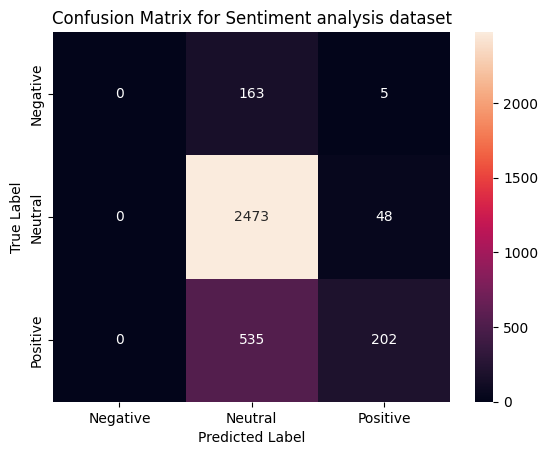

Model loaded from path :custom_bert_model.bin
Local Wav2Vec2 processor and model found. Loading from local directory.
Step 1 / 215 | Pipeline Eval loss : 0.6574205160140991
Step 2 / 215 | Pipeline Eval loss : 1.034090518951416
Step 3 / 215 | Pipeline Eval loss : 0.531771183013916
Step 4 / 215 | Pipeline Eval loss : 0.20735439658164978
Step 5 / 215 | Pipeline Eval loss : 0.7105944156646729
Step 6 / 215 | Pipeline Eval loss : 0.755276083946228
Step 7 / 215 | Pipeline Eval loss : 0.5784748196601868
Step 8 / 215 | Pipeline Eval loss : 0.5784557461738586
Step 9 / 215 | Pipeline Eval loss : 0.6005702018737793
Step 10 / 215 | Pipeline Eval loss : 0.6952868103981018
Step 11 / 215 | Pipeline Eval loss : 0.8656256794929504
Step 12 / 215 | Pipeline Eval loss : 1.0646796226501465
Step 13 / 215 | Pipeline Eval loss : 0.939874529838562
Step 14 / 215 | Pipeline Eval loss : 0.872765064239502
Step 15 / 215 | Pipeline Eval loss : 0.5229593515396118
Step 16 / 215 | Pipeline Eval loss : 1.9176567792892456

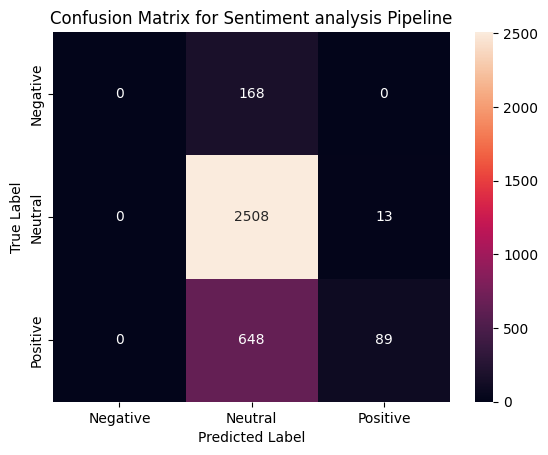

Model loaded from path :custom_bert_model.bin
Local Wav2Vec2 processor and model found. Loading from local directory.
Neutral


In [54]:
if __name__ == "__main__":

  wandb.login(key=wandb_token)
  run = wandb.init(project="DIT-Wav2Vec-Bert-Sentiment-Analysis-project")
  bert_train_dataset = CustomBertDataset(TRAIN_DS_PATH, "fine-tune_raw")
  bert_test_dataset = CustomBertDataset(TEST_DS_PATH, "test_raw")
  print(f"Size of bert dataset : {len(bert_train_dataset)}")
  """train_dataset = Subset(our_bert_dataset, range(int(len(our_bert_dataset)*0.8)))
  test_dataset = Subset(our_bert_dataset, range(int(len(our_bert_dataset)*0.8), len(our_bert_dataset)))"""

  train_dataloader = DataLoader(bert_train_dataset, batch_size=BATCH_SIZE, shuffle=True)
  test_dataloader = DataLoader(bert_test_dataset, batch_size=BATCH_SIZE, shuffle=False)

  our_bert_model = CustomBertModel(bert_train_dataset.num_class)
  our_bert_model = our_bert_model.to(device)

  loss_fn = nn.CrossEntropyLoss()
  optimizer = optim.SGD(filter(lambda p: p.requires_grad, our_bert_model.parameters()), lr=0.01)

  train_step(our_bert_model, train_dataloader, loss_fn, optimizer)
  eval_step(test_dataloader, loss_fn, bert_train_dataset.num_class)
  eval_pipeline_step(test_dataloader, loss_fn, bert_train_dataset.num_class)

  test_inference_audio_path = "/content/dev_raw/id10012_0AXjxNXiEzo_00001.flac"
  print(get_audio_sentiment(test_inference_audio_path))